Methods of Machine Learning and Intellectual Analysis of Data (Learning course) \
Bohdan Pavlyshenko (https://www.linkedin.com/in/bpavlyshenko/) \
Youtube video: https://www.youtube.com/watch?v=kEVzNQqfu9A&list=PLMQt7tnruMvF1jetHNUKjMtHKSp78H2bb&index=13

# Text Classification (Airline Sentiments)

Used resource:\
https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

In [ ]:
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, log_loss, f1_score, roc_curve, auc
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input,concatenate,Flatten
from tensorflow.keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout,GRU
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold, train_test_split
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def text_processing(df, txt_col='text'):
    text_list=df[txt_col].tolist()
    text_list_processed=[]
    for text in text_list:
        text=text.lower()
        text=re.sub(r'[\.\,\?\:\;\!\-\'\"]','',text)
        text=re.sub(r'\d+','',text)
        words=re.split(r'\W+', text)
        text=' '.join(words)
        text_list_processed.append(text)
    df[txt_col]=text_list_processed
    return(df)

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/LNU/2 course/2 semester/Data processing systems/jupyter_notebooks_data/data/airline_sentiments.csv',encoding='latin1')
df.shape

(14640, 20)

In [ ]:
df['target']=df['airline_sentiment']
df=text_processing(df, txt_col='text')
train_df,test_df=train_test_split(df.copy(), test_size=0.3, random_state=5)
le = LabelEncoder()
train_df['target_enc']=le.fit_transform(train_df['target'])
test_df['target_enc']=le.transform(test_df['target'])
y_train=train_df['target_enc'].values
y_test=test_df['target_enc'].values
classes=le.classes_
n_class=len(le.classes_)
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,...,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone,target
0,681448150,False,finalized,3,2/25/15 5:24,neutral,1.0000,NaN,NaN,Virgin America,...,cairdin,NaN,0,virginamerica what dhepburn said,NaN,2/24/15 11:35,5.703060e+17,NaN,Eastern Time (US & Canada),neutral
1,681448153,False,finalized,3,2/25/15 1:53,positive,0.3486,NaN,0.0000,Virgin America,...,jnardino,NaN,0,virginamerica plus youve added commercials to...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada),positive
2,681448156,False,finalized,3,2/25/15 10:01,neutral,0.6837,NaN,NaN,Virgin America,...,yvonnalynn,NaN,0,virginamerica i didnt today must mean i need ...,NaN,2/24/15 11:15,5.703010e+17,Lets Play,Central Time (US & Canada),neutral
3,681448158,False,finalized,3,2/25/15 3:05,negative,1.0000,Bad Flight,0.7033,Virgin America,...,jnardino,NaN,0,virginamerica its really aggressive to blast ...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada),negative
4,681448159,False,finalized,3,2/25/15 5:50,negative,1.0000,Can't Tell,1.0000,Virgin America,...,jnardino,NaN,0,virginamerica and its a really big bad thing ...,NaN,2/24/15 11:14,5.703010e+17,NaN,Pacific Time (US & Canada),negative


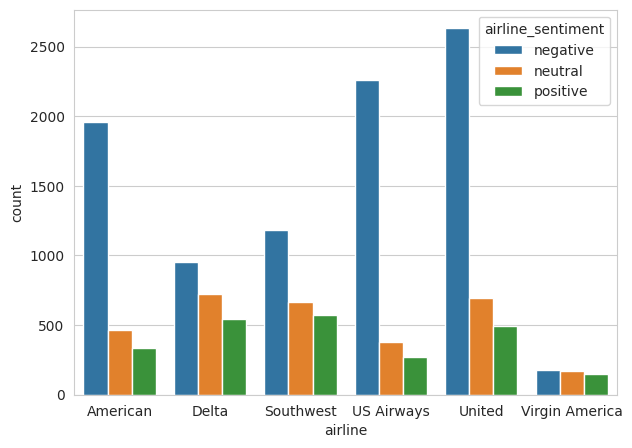

In [ ]:
df_aggr=df.groupby(['airline','airline_sentiment']).size().to_frame('count').reset_index()
fig, ax = plt.subplots(figsize=(7,5))
_= sns.barplot(x='airline', y="count", hue='airline_sentiment', data=df_aggr)

In [ ]:
max_len=50
max_feat=10000
embed_dim=50
lr=0.0001
rnn_type='gru'
n_rnn=128
n_dense=32
dropout_v=0.1
loss_v='categorical_crossentropy'
metric_v='accuracy'

In [ ]:
text_v = 'text'
target_v='target_enc'
n_class=train_df.target.nunique()
print(f'n_class:{n_class}')
tk = text.Tokenizer(num_words=max_feat)
tk.fit_on_texts(train_df['text'])
train_tk = tk.texts_to_sequences(train_df[text_v])
test_tk = tk.texts_to_sequences(test_df[text_v])
X_train = sequence.pad_sequences(train_tk, maxlen=max_len)
X_test = sequence.pad_sequences(test_tk, maxlen=max_len)
word_ind = tk.word_index
y_train,y_test=to_categorical(train_df[target_v].values),to_categorical(test_df[target_v].values)
word_ind = {e:i for e,i in word_ind.items() if i <= max_feat}
print ('word index size:',len(word_ind))

n_class:3
word index size: 10000


In [ ]:
inp = Input(shape=(max_len, ))
x = Embedding(max_feat, embed_dim)(inp)
if (rnn_type=='gru'):
    x = Bidirectional(GRU(n_rnn))(x)
if (rnn_type=='lstm'):
    x = Bidirectional(LSTM(n_rnn))(x)
x = Dropout(dropout_v)(x)
x = Dense(n_dense, activation="relu")(x)
x = Dropout(dropout_v)(x)
x=Dense(n_class, activation="softmax")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss=loss_v,optimizer=optimizers.Adam(lr=lr), metrics=[metric_v])

In [ ]:
batch_size=256
epochs= 25

early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=25)
model_train_history=model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                                  validation_data=(X_test, y_test), callbacks=[early_stop])

Epoch 1/25
41/41 [==============================] - 40s 679ms/step - loss: 0.9077 - accuracy: 0.6214 - val_loss: 0.7337 - val_accuracy: 0.6837
Epoch 2/25
41/41 [==============================] - 20s 502ms/step - loss: 0.6296 - accuracy: 0.7252 - val_loss: 0.6144 - val_accuracy: 0.7377
Epoch 3/25
41/41 [==============================] - 23s 566ms/step - loss: 0.4657 - accuracy: 0.8026 - val_loss: 0.5957 - val_accuracy: 0.7593
Epoch 4/25
41/41 [==============================] - 20s 492ms/step - loss: 0.3699 - accuracy: 0.8560 - val_loss: 0.6193 - val_accuracy: 0.7721
Epoch 5/25
41/41 [==============================] - 22s 530ms/step - loss: 0.2850 - accuracy: 0.8968 - val_loss: 0.6472 - val_accuracy: 0.7684
Epoch 6/25
41/41 [==============================] - 24s 595ms/step - loss: 0.2154 - accuracy: 0.9294 - val_loss: 0.6894 - val_accuracy: 0.7707
Epoch 7/25
41/41 [==============================] - 28s 692ms/step - loss: 0.1626 - accuracy: 0.9459 - val_loss: 1.0733 - val_accuracy: 0.7113

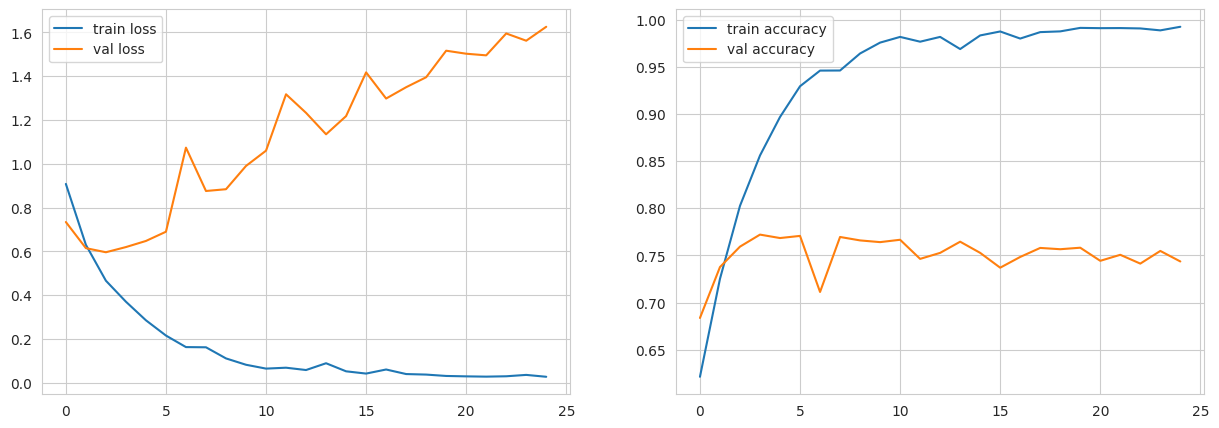

In [ ]:
history=model_train_history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
loss_ts = history.history['loss']
val_loss_ts= history.history['val_loss']
loss_nn_df=pd.DataFrame({'train loss':loss_ts,'val loss':val_loss_ts})
loss_nn_df.plot(ax=axes[0])
acc_ts = history.history['accuracy']
val_acc_ts= history.history['val_accuracy']
loss_nn_df=pd.DataFrame({'train accuracy':acc_ts,'val accuracy':val_acc_ts})
loss_nn_df.plot(ax=axes[1])
plt.show()

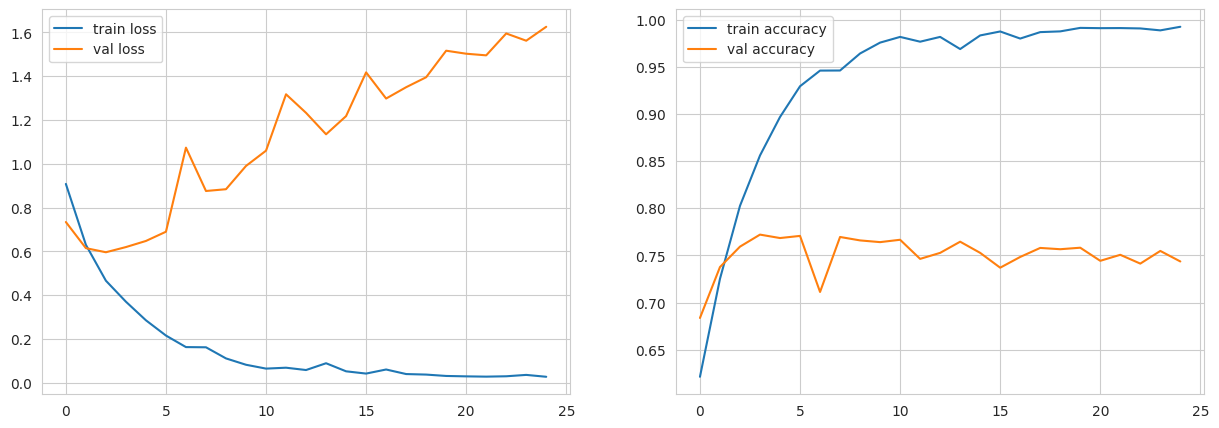

In [ ]:
history=model_train_history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
loss_ts = history.history['loss']
val_loss_ts= history.history['val_loss']
loss_nn_df=pd.DataFrame({'train loss':loss_ts,'val loss':val_loss_ts})
loss_nn_df.plot(ax=axes[0])
acc_ts = history.history['accuracy']
val_acc_ts= history.history['val_accuracy']
loss_nn_df=pd.DataFrame({'train accuracy':acc_ts,'val accuracy':val_acc_ts})
loss_nn_df.plot(ax=axes[1])
plt.show()

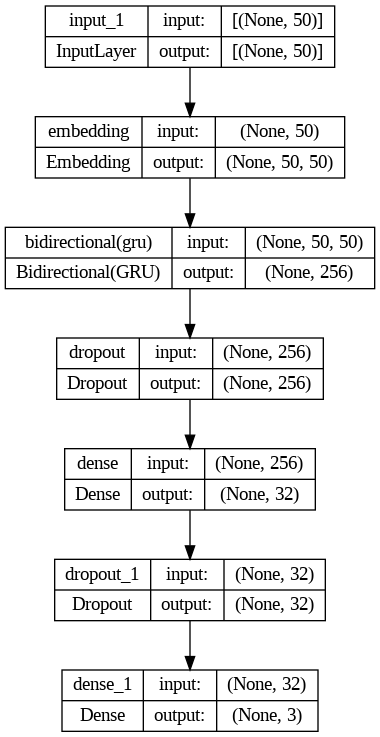

In [ ]:
tf.keras.utils.plot_model(model, to_file='img.png', show_shapes=True, show_layer_names=True)

In [ ]:
pred_p = model.predict(X_test)
pred=np.array(np.argmax(pred_p, axis=1))
test_df['pred']=pred
test_pred_colnames=[]
for i in range(n_class):
    colname='pred_'+str(classes[i])
    test_pred_colnames.append(colname)
    test_df[colname] = pred_p[:,i]
test_df['pred_class']=[classes[i] for i in test_df['pred'].values]

138/138 [==============================] - 4s 22ms/step


In [ ]:
test_df.head(10)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,...,tweet_id,tweet_location,user_timezone,target,target_enc,pred,pred_negative,pred_neutral,pred_positive,pred_class
111,681448397,False,finalized,3,2/25/15 8:17,positive,0.6806,NaN,NaN,Virgin America,...,5.698740e+17,"New York City, NY",Central Time (US & Canada),positive,2,1,8.105375e-04,9.392394e-01,5.995006e-02,neutral
9369,681460608,False,finalized,3,2/25/15 9:04,negative,1.0000,Customer Service Issue,0.6682,US Airways,...,5.699680e+17,NaN,Buenos Aires,negative,0,0,9.999998e-01,6.139086e-08,3.681069e-08,negative
3113,681452732,False,finalized,3,2/25/15 3:04,positive,0.6608,NaN,NaN,United,...,5.686630e+17,NJ,Eastern Time (US & Canada),positive,2,2,1.829879e-04,1.302338e-02,9.867936e-01,positive
7235,681457733,False,finalized,3,2/25/15 7:55,negative,1.0000,Late Flight,1.0000,Delta,...,5.698540e+17,NaN,Eastern Time (US & Canada),negative,0,0,9.999984e-01,1.353582e-06,2.784869e-07,negative
5002,681454998,False,finalized,3,2/25/15 4:12,negative,1.0000,Cancelled Flight,1.0000,Southwest,...,5.695550e+17,NaN,NaN,negative,0,0,9.999157e-01,5.656677e-05,2.768447e-05,negative
10916,681462210,False,finalized,3,2/25/15 4:26,positive,1.0000,NaN,NaN,US Airways,...,5.687860e+17,NaN,NaN,positive,2,2,3.553791e-11,5.640356e-09,9.999999e-01,positive
14123,681679281,False,finalized,3,2/25/15 19:11,negative,1.0000,Late Flight,0.3706,American,...,5.696640e+17,NaN,Pacific Time (US & Canada),negative,0,0,9.999999e-01,1.053972e-08,2.492532e-08,negative
4139,681454126,False,finalized,3,2/25/15 3:52,neutral,0.7083,NaN,0.0000,United,...,5.678080e+17,All Over The World,NaN,neutral,1,1,1.283850e-04,9.982019e-01,1.669691e-03,neutral
7248,681457746,False,finalized,3,2/25/15 3:53,positive,1.0000,NaN,NaN,Delta,...,5.697750e+17,California,Arizona,positive,2,2,1.107052e-04,3.023331e-04,9.995870e-01,positive
4420,681454410,False,finalized,3,2/25/15 5:18,negative,1.0000,Customer Service Issue,1.0000,Southwest,...,5.702640e+17,"San Diego, CA",Pacific Time (US & Canada),negative,0,0,9.999997e-01,1.153496e-07,6.369640e-08,negative


In [ ]:
conf_matr_df=pd.DataFrame(confusion_matrix(test_df['target'],\
            test_df['pred_class']),columns=classes,index=classes)
conf_matr_df

,negative,neutral,positive
negative,2250,366,143
neutral,254,531,121
positive,120,122,485


In [ ]:
log_loss_err=log_loss(y_test,pred_p)
log_loss_err

1.6054152007445819

In [ ]:
metrics.accuracy_score(test_df['target'], test_df['pred_class'])

0.7436247723132969

In [ ]:
print(metrics.classification_report(test_df['target'], test_df['pred_class']))

              precision    recall  f1-score   support

    negative       0.86      0.82      0.84      2759
     neutral       0.52      0.59      0.55       906
    positive       0.65      0.67      0.66       727

    accuracy                           0.74      4392
   macro avg       0.68      0.69      0.68      4392
weighted avg       0.75      0.74      0.75      4392



In [ ]:
scores=precision_recall_fscore_support(test_df['target'], test_df['pred_class'])
scores_df=pd.DataFrame({'precision':scores[0], 'recall':scores[1], 'f1-score':scores[2]}, index=classes)
scores_df

,precision,recall,f1-score
negative,0.857470,0.815513,0.835965
neutral,0.521099,0.586093,0.551688
positive,0.647530,0.667125,0.657182


In [ ]:
max_feat=30000
ngram_range=(1,1)
text_var='text'
vect = TfidfVectorizer(max_features=max_feat,ngram_range=ngram_range)
X_train = vect.fit_transform(train_df[text_var].values)
X_test = vect.transform(test_df[text_var].values)
le = LabelEncoder()
train_df['target_enc']=le.fit_transform(train_df['target'])
test_df['target_enc']=le.transform(test_df['target'])
y_train=train_df['target_enc'].values
y_test=test_df['target_enc'].values
classes=le.classes_

In [ ]:
clf=RandomForestClassifier(n_estimators=500,n_jobs=-1)
_=clf.fit(X_train, y_train)
pred = clf.predict(X_test)

In [ ]:
test_df['pred']=pred
test_pred_colnames=[]
test_df['pred_class']=[classes[int(i)] for i in test_df['pred'].values]

In [ ]:
test_df[['target','pred_class']]

,target,pred_class
111,positive,neutral
9369,negative,negative
3113,positive,negative
7235,negative,negative
5002,negative,negative
...,...,...
9560,neutral,negative
6952,negative,negative
1260,negative,negative
11513,positive,positive


In [ ]:
metrics.accuracy_score(test_df['target'], test_df['pred_class'])

0.7540983606557377

In [ ]:
print(metrics.classification_report(test_df['target'],test_df['pred_class']))

              precision    recall  f1-score   support

    negative       0.75      0.97      0.85      2759
     neutral       0.68      0.37      0.48       906
    positive       0.86      0.43      0.57       727

    accuracy                           0.75      4392
   macro avg       0.76      0.59      0.63      4392
weighted avg       0.76      0.75      0.73      4392



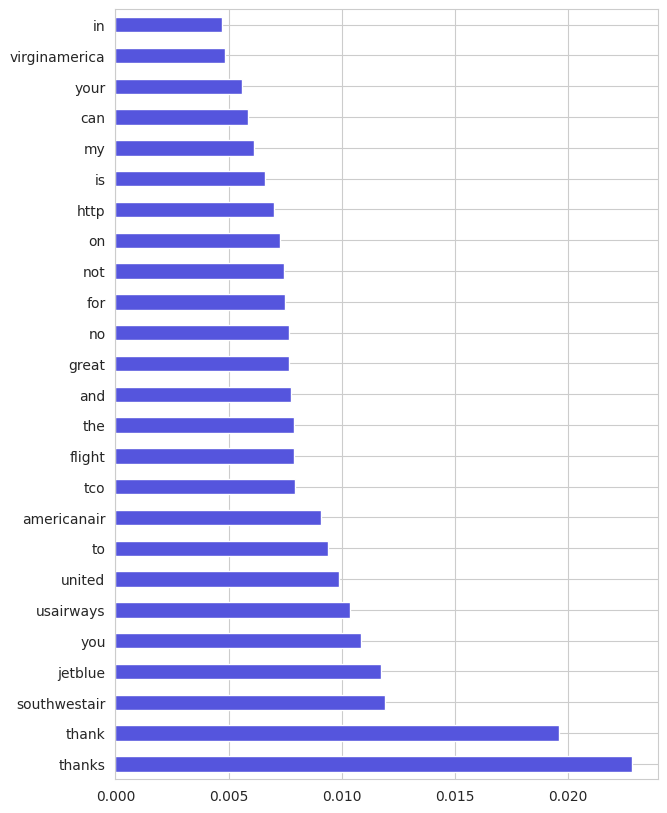

In [ ]:
n_feat = 25
f_imp = clf.feature_importances_
feature_names = list(np.asarray(vect.get_feature_names_out()))
f_imp_s=pd.Series(f_imp,index=feature_names)
f_imp_s.sort_values(ascending=False, inplace=True)
fgr=f_imp_s[0:n_feat].plot(kind='barh',title='',figsize=(7,10),color='#5555dd')
plt.show()